In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [3]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [4]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [5]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311605584e-48, 'percent_dependent'),
 (1.4293811306586728e-24, '5_year_declining_balance'),
 (1.3527931483012968e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484509366e-15, 'fafsa_sent'),
 (2.3099399670297893e-10, '7_yr_repayment_completion'),
 (5.332261659651424e-09, 'first_generation'),
 (1.407934457452164e-08, 'part_time_share'),
 (1.516370320447573e-08, 'dep_low_income'),
 (5.389960032435474e-08, 'percent_pell_grant'),
 (2.9423628117768117e-06, 'students_with_any_loans'),
 (9.035892891499908e-

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

For me, it is very intuitive that the online only status has one of the most significant relationships with for-profit status. When I did an internet search for for-profit colleges, the first results were colleges which I know to be online only. A surprising result is how insignificant the relationship between the for-profit status and the federal loan rate. I would expect that non-profit colleges receive benefits in the form of a lower federal loan rate which would then make the federal loan rate be a very significant explanatory variable. However, the federal loan rate appears to be one of the more insignificant variables contributing to the for-profit status. The accreditation has the second largest effect on the for-profit status. I would guess that accreditation is so important because most accredited colleges are non-profits and the council that accredits colleges is comprised of repre

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
model = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', max_iter = 10000)
model.fit(X_train, y_train)
y_proba_LR = model.predict_proba(X_test)[:,1]
print('Accuracy:',model.score(X_test,y_test))

Accuracy: 0.9010880316518298


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [7]:
param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)

print(model.best_params_, model.best_estimator_)

{'n_neighbors': 5} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


Optimal Number of Nearest Neighbors: 5

In [9]:
model = model.best_estimator_

print('Accuracy:', model.score(X_test, y_test))

Accuracy: 0.8961424332344213


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [10]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3835
           1       0.88      0.90      0.89      2905

    accuracy                           0.91      6740
   macro avg       0.90      0.91      0.90      6740
weighted avg       0.91      0.91      0.91      6740



Precision: 
In all instances predicted as non-profit, 0.93 of the predictions were correct.
In all insances predicted as for-profit, 0.90 of the predictions were correct.

Recall:
0.92 of all non-profit instances were predicted as non-profit.
0.91 of a for-profit instances were predicted as for-profit.

Support:
There were 3835 cases of non-profit.
There were 2905 cases of for-profit.

Average:
For all of the data, 0.92 of the predictions were correct.



5.Print a confusion matrix and describe what it means in your context.

In [11]:
print(confusion_matrix(y_test, model.predict(X_test)))

[[1029  118]
 [  92  783]]


108 of the non-profits were predicted incorrectly while 94 of the for-profits were predicted incorrectly.

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

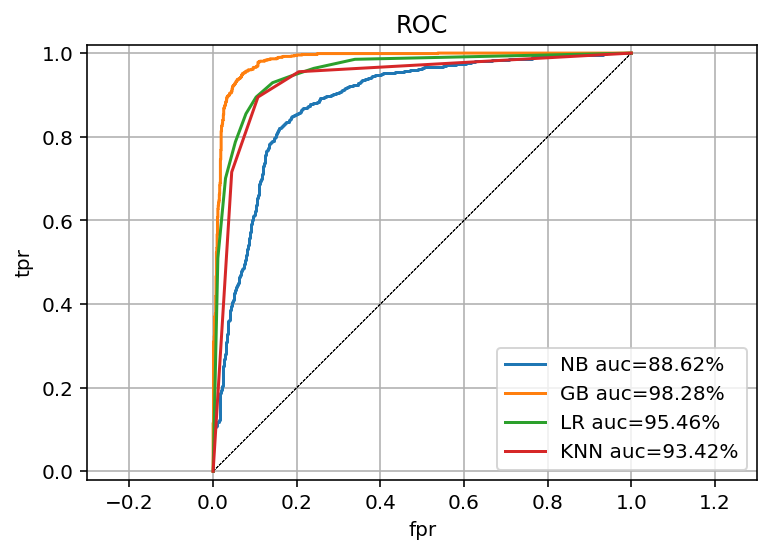

In [12]:
def plot_roc(ytrue, yproba, model, title='ROC'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
y_proba_LR = model.predict_proba(X_test)[:, 1]
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_proba_NB = model.predict_proba(X_test)[:, 1]
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_proba_GB = model.predict_proba(X_test)[:, 1]
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_proba_KNN = model.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_proba_NB, "NB")
plot_roc(y_test, y_proba_GB, "GB")
plot_roc(y_test, y_proba_LR, "LR")
plot_roc(y_test, y_proba_KNN,"KNN")


7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

(-2.941558886777559, 3.1784411132224464)

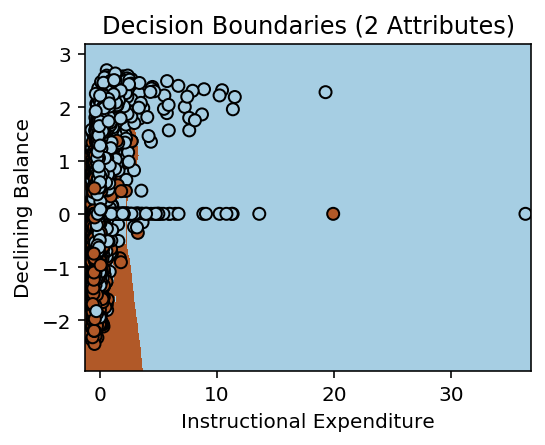

In [13]:
X = df[['instructional_expenditure_per_fte','5_year_declining_balance']]
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)
Q = X.values
h = .02  
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(X.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision Boundaries (2 Attributes)')
plt.xlabel('Instructional Expenditure')
plt.ylabel('Declining Balance')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

There seems to be a pretty defined boundary for these predictors.

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_proba_Forest = model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_proba_SVM = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7763883001271725


10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

In [16]:
def plot_roc(ytrue, yproba, model, title='ROC'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
y_proba_LR = model.predict_proba(X_test)[:, 1]
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_proba_NB = model.predict_proba(X_test)[:, 1]
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_proba_GB = model.predict_proba(X_test)[:, 1]
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_proba_KNN = model.predict_proba(X_test)[:, 1]
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_proba_Forest = model.predict_proba(X_test)[:,1]
model = svm.SVC(probability=True)
model.fit(X_train, y_train)
y_proba_SVM = model.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_proba_NB, "NB")
plot_roc(y_test, y_proba_GB, "GB")
plot_roc(y_test, y_proba_LR, "LR")
plot_roc(y_test, y_proba_KNN,"KNN")
plot_roc(y_test, y_proba_Forest,"FC")
plot_roc(y_test, y_proba_SVM,"SVM")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [0]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print(model.predict([X_test.iloc[1]]))
print(y_test.iloc[1])
#Predicted the school to be non-profit
#Prediction was correct because that school was a non-profit

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [12]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.head()
X_scaled.columns = X.columns

Score = X_scaled.assign(Score = lambda x:
                X_scaled['retention'] + X_scaled['7_yr_repayment_completion'] - X_scaled['loan_principal']
                        )
Score["Rank"] = Score["Score"].rank(ascending = True)
names = df[['name']]
Score = Score.join(names)
Score = Score.sort_values(by = 'Rank', ascending = False)
Score = Score.assign(Rank = lambda x: Score['Rank'])
Score.tail(15)



#Rank = X.assign(Rank = lambda x:
               # 10*X['retention'] + 5*X['7_yr_repayment_completion'] - 7*(X['loan_principal']) + #4*X['under_investigation'])

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit,Score,Rank,name
5723,-0.242226,-1.650960e+00,-0.302187,-0.075299,-0.101702,1.103434,0.562069,-0.836340,-0.292895,-0.103598,...,2.572123,0.115018,0.486049,0.789502,0.811207,0.536867,-0.870343,-5.047188,15.0,NaN
274,-0.440630,-1.309612e+00,-0.103451,-0.075299,-0.101702,0.136315,0.562069,-0.492225,-0.381771,0.868652,...,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,-0.870343,-5.051759,13.5,Charles of Italy Beauty College
196,-0.368832,-1.309612e+00,-0.103451,-0.075299,-0.101702,0.136315,0.562069,-1.623760,-0.601311,0.449164,...,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,-0.870343,-5.051759,13.5,Aveda Institute-Phoenix
4261,-0.465293,-4.523811e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.455991,-0.026428,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,1.148972,-5.138196,12.0,Nebraska Indian Community College
4738,-0.455245,-2.155590e+00,-0.302187,-0.075299,-0.101702,0.136315,-0.197423,-2.332493,-0.639772,-0.574649,...,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972,-5.210640,11.0,Bryant & Stratton College-Albany
3278,-0.455062,-3.011209e+00,-0.103451,-0.075299,-0.101702,0.136315,-0.197423,-1.889189,-0.488007,-0.058087,...,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972,-5.463825,10.0,Maryland Beauty Academy
5475,-0.451043,-2.916712e+00,-0.103451,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,0.085272,-0.177509,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,1.148972,-5.550554,9.0,University of Science and Arts of Oklahoma
2524,-0.407562,-3.238132e+00,2.877578,-0.075299,-0.101702,-0.830804,-0.197423,-1.812719,-0.482913,-0.217083,...,-0.388784,0.115018,0.486049,0.789502,0.811207,0.536867,1.148972,-5.597350,8.0,Ivy Tech Community College-South Central
4055,-0.457985,-3.605193e+00,-0.202819,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,0.147226,0.528894,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,-0.870343,-5.731443,7.0,Miller-Motte College-Raleigh
1086,-0.434601,7.850651e-15,-0.302187,-0.075299,-0.101702,1.103434,0.562069,0.150567,0.041094,0.465459,...,-0.388784,0.115018,-2.057406,0.789502,0.811207,0.536867,1.148972,-5.940042,6.0,Thuy Princess Beauty College


13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

See blog post.

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.

See blog post.